In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime, date
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Our dataset is a set of issues of a newspaper called *The Liberator* <https://en.wikipedia.org/wiki/The_Liberator_(newspaper)>, which was active for the last few decades of the abolitionist period.

In [7]:
! tar xvzf TheLiberator.tgz

TheLiberator/
TheLiberator/1848-09-01.txt
TheLiberator/1850-11-01.txt
TheLiberator/1840-05-01.txt
TheLiberator/1839-11-01.txt
TheLiberator/1844-11-01.txt
TheLiberator/1838-06-01.txt
TheLiberator/1860-06-01.txt
TheLiberator/1834-03-01.txt
TheLiberator/1841-01-01.txt
TheLiberator/1857-05-01.txt
TheLiberator/1847-01-01.txt
TheLiberator/1832-12-01.txt
TheLiberator/1861-03-01.txt
TheLiberator/1864-01-01.txt
TheLiberator/1851-11-01.txt
TheLiberator/1851-08-01.txt
TheLiberator/1861-02-01.txt
TheLiberator/1833-06-01.txt
TheLiberator/1854-09-01.txt
TheLiberator/1831-01-01.txt
TheLiberator/1850-03-01.txt
TheLiberator/1843-12-01.txt
TheLiberator/1849-06-01.txt
TheLiberator/1836-10-01.txt
TheLiberator/1861-11-01.txt
TheLiberator/1834-02-01.txt
TheLiberator/1850-02-01.txt
TheLiberator/1863-05-01.txt
TheLiberator/1856-08-01.txt
TheLiberator/1864-04-01.txt
TheLiberator/1842-04-01.txt
TheLiberator/1865-12-01.txt
TheLiberator/1844-03-01.txt
TheLiberator/1854-12-01.txt
TheLiberator/1858-10-01.txt
TheLib

In [2]:
#files = sorted(glob('TheLily/*'))
files = sorted(glob('TheLiberator/*'))

In [3]:
files[-3:]

['TheLiberator/1864-07-01.txt',
 'TheLiberator/1865-09-01.txt',
 'TheLiberator/1865-12-01.txt']

Let's build a vectorizer to read it in. 

Note the flag `binary`. If we set `binary=True`, this would mean that each word is counted at most once per document.

In [4]:
vect = CountVectorizer(input='filename',min_df=10,binary=False)

In [5]:
X = vect.fit_transform(files)

In [29]:
X.shape

(59, 8305)

**Your turn**: build another vectorizer, which includes all words that appear in at least 20 documents

In [11]:
vect2 = CountVectorizer(input='filename',min_df=10,max_df=0.75)
X2 = vect2.fit_transform(files)
X2.shape

(59, 6911)

Let's print the most common words in 1851. To do this, we'll import `dateutil.parser`, which can parse the dates from the filenames.

In [13]:
from dateutil.parser import parse

In [14]:
files[4]

'TheLiberator/1833-06-01.txt'

In [15]:
os.path.basename(files[4])

'1833-06-01.txt'

In [16]:
os.path.basename(files[4])[:-4]

'1833-06-01'

In [17]:
parse(os.path.basename(files[4])[:-4])

datetime.datetime(1833, 6, 1, 0, 0)

In [18]:
# this list comprehension parses each of the dates in the filenames
dates = [parse(os.path.basename(filename)[:-4],'')
         for filename 
         in files]

In [19]:
print(dates[-3:])
print(files[-3:])

[datetime.datetime(1864, 7, 1, 0, 0), datetime.datetime(1865, 9, 1, 0, 0), datetime.datetime(1865, 12, 1, 0, 0)]
['TheLiberator/1864-07-01.txt', 'TheLiberator/1865-09-01.txt', 'TheLiberator/1865-12-01.txt']


Now we want to select a slice of X, corresponding only to editions in 1851.

We'll use the `enumerate` function to find the indices of dates that match the desired condition.

In [20]:
[(i,date) for i,date in enumerate(dates) if date.year==1851]

[(34, datetime.datetime(1851, 8, 1, 0, 0)),
 (35, datetime.datetime(1851, 11, 1, 0, 0))]

In [30]:
X_1851 = X[[i for i,date in enumerate(dates) if date.year==1851],]

In [22]:
X_1851.shape

(2, 8305)

So `X_1851` contains two instances, corresponding to the two editions published in 1851. (Actually, we're working with a small sample of the full dataset, there were several other editions published in that year.)

To find the most common words in this sample, let's construct an inverted index from the columns of `X` back to the vocabulary. 

In [24]:
ivoc = {j:i for i,j in vect.vocabulary_.items()}

In [28]:
np.array(X_1851.sum(axis=0))[0]

array([ 2, 14,  4, ...,  0,  0,  0], dtype=int64)

In [25]:
[ivoc[i] for i in np.array(X_1851.sum(axis=0))[0].argsort()[::-1][:5]]

['the', 'of', 'and', 'to', 'in']

Not too interesting, but we're just getting started. 

**Your turn** Build a matrix containing the counts for editions published in the 1860s.

In [31]:
X_1860s = X[[i for i,date in enumerate(dates) 
             if (date.year>=1860) and (date.year<1870)],]

In [32]:
# make sure you verify this
X_1860s.shape

(11, 8305)

# Pointwise mutual information

Rather than look at the most common words in each year or set of years, let's look at the words that have high *pointwise mutual information* with the year. This is defined as:

\begin{equation}
PMI(i,j) = \log \frac{P(i,j)}{P(i)\times P(j)} = \log P(i,j) - \log P(i) - \log P(j)
\end{equation}

We'll now introduce code to compute each part of this equation.

In [33]:
# this computes $p(i)$, where $i$ is a word
def get_p_word(X):
    X_tot = np.array(X.sum(axis=0))[0]
    return X_tot / X.sum()

In [34]:
P_base =get_p_word(X)

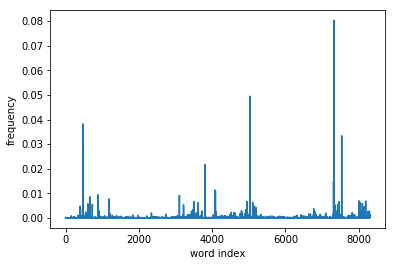

In [35]:
plt.plot(P_base)
plt.xlabel('word index')
plt.ylabel('frequency');

In [36]:
print([ivoc[i] for i in P_base.argsort()[::-1][:5]])
print(sorted(P_base)[::-1][:5])

['the', 'of', 'and', 'to', 'in']
[0.080353468880321952, 0.049455292548612188, 0.038205106504679551, 0.033368839757077697, 0.021727596662590724]


Now let's compute $P(year)$ and $P(word,year)$.

To do this, we'll write a function that returns a sum of word counts for a given year.

In [38]:
all_years = sorted(set([date.year for date in dates]))
print(all_years)

[1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865]


In [39]:
def get_X_year(X,dates,year):
    return np.array(X[[i 
              for i,date 
              in enumerate(dates) 
              if date.year==year],].sum(axis=0))[0]

In [40]:
print(get_X_year(X,dates,1851))
print(X_1851.sum(axis=0))

[ 2 14  4 ...,  0  0  0]
[[ 2 14  4 ...,  0  0  0]]


Now let's create this vector for each year.

In [41]:
X_years = [get_X_year(X,dates,year) for year in all_years]

In [42]:
X_years[:3]

[array([ 0, 21,  3, ...,  2,  0,  0], dtype=int64),
 array([ 2, 11, 12, ...,  2,  3,  1], dtype=int64),
 array([47, 12,  5, ...,  0,  0,  1], dtype=int64)]

This is a list of arrays. We can combine this into a single array:

In [43]:
X_all_years = np.array(X_years)

In [44]:
X_all_years

array([[ 0, 21,  3, ...,  2,  0,  0],
       [ 2, 11, 12, ...,  2,  3,  1],
       [47, 12,  5, ...,  0,  0,  1],
       ..., 
       [ 0,  1, 10, ...,  0,  1,  0],
       [ 1, 20, 13, ...,  5,  2,  5],
       [ 1, 19,  6, ...,  3,  1,  1]], dtype=int64)

In [45]:
P_year = X_all_years.sum(axis=1) / X_all_years.sum()

In [47]:
P_year

array([ 0.01411366,  0.02101902,  0.00972623,  0.04188513,  0.0143407 ,
        0.01494947,  0.0188828 ,  0.01691759,  0.05252363,  0.01493721,
        0.06889783,  0.06110763,  0.06352518,  0.06204324,  0.03534689,
        0.0140693 ,  0.02768742,  0.02650083,  0.01430919,  0.04323398,
        0.02164997,  0.01436113,  0.03003085,  0.02764773,  0.01518527,
        0.02963687,  0.01519111,  0.02934854,  0.01496873,  0.01472651,
        0.04676459,  0.01539072,  0.01451872,  0.0445951 ,  0.02996723])

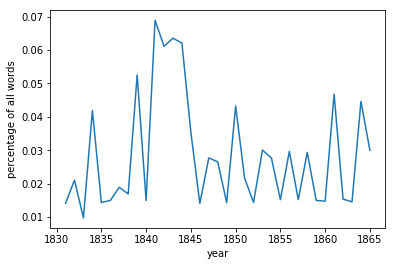

In [48]:
plt.plot(all_years,P_year)
plt.xlabel('year')
plt.ylabel('percentage of all words');

**Optional exercise** Create the same plot for months rather than years.

Now we're ready to compute the PMI.

In [50]:
all_years.index(1851)

20

In [51]:
X_all_years

array([[ 0, 21,  3, ...,  2,  0,  0],
       [ 2, 11, 12, ...,  2,  3,  1],
       [47, 12,  5, ...,  0,  0,  1],
       ..., 
       [ 0,  1, 10, ...,  0,  1,  0],
       [ 1, 20, 13, ...,  5,  2,  5],
       [ 1, 19,  6, ...,  3,  1,  1]], dtype=int64)

In [56]:
idx_1851 = all_years.index(1851)
pmi_1851 = np.log(X_all_years[idx_1851,:]/X_all_years.sum()) - np.log(P_base) - np.log(P_year[idx_1851])

/home/jacob/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


That divide by zero error comes from taking the logarithm of zero, which will happen for every word that does not appear in the target year. Let's look at the output:

In [57]:
pmi_1851

array([-0.72112563,  0.1858105 , -0.8424113 , ...,        -inf,
              -inf,        -inf])

numpy handles this pretty well, putting a value of `-inf` in the list. 

that means we can go ahead and use argsort to find the highest PMI words.

In [58]:
[ivoc[i] for i in pmi_1851.argsort()[::-1][:5]]

['1851', 'austria', 'fraternity', 'problem', 'theyshould']

The top word is 1851! This is a good sign.

**Your turn** Write a function that takes the year as an argument, and returns the PMI for that year.

In [ ]:
def get_pmi_year(X_all_years,X_base,p_year,year):
    # your code here

    

Here's how the output should look.

In [209]:
for year in all_years:
    print(year,[ivoc[i] for i in get_pmi_year(X_all_years,X_base,p_year,year).argsort()[::-1][:5]])

1831 ['weep', '1831', 'landlord', '1830', 'coach']
1832 ['cup', 'deaths', 'deputy', 'refute', 'cholera']
1833 ['planter', 'isle', 'spectator', '00', 'solomon']
1834 ['overseers', 'chorus', '1834', 'augusta', 'overseer']
1835 ['tracy', 'pull', '1835', 'purvis', 'madam']
1836 ['glasgow', 'opponent', 'kidnapped', 'boasting', 'searched']
1837 ['swallow', 'braintree', '1837', 'clerical', 'deprecate']
1838 ['mob', 'remonstrances', 'kidnappers', 'erected', 'nought']
1839 ['1839', 'harriet', 'disguise', 'marlboro', 'hilton']
1840 ['goodell', 'manifesto', 'harrison', 'follen', 'emancipator']
1841 ['1841', 'pierpont', 'lucretia', 'resistant', 'betrays']
1842 ['1842', 'trains', 'giddings', 'nelson', 'pauper']
1843 ['1843', 'stabbed', 'perkins', 'sham', 'bro']
1844 ['1844', 'birney', 'polk', 'bath', 'bates']
1845 ['writ', 'drunkenness', 'prosecuted', 'insurrections', 'employer']
1846 ['rio', 'drunkard', 'cobb', 'del', 'elegance']
1847 ['campbell', 'edinburgh', 'sand', 'thepoor', 'carved']
1848 ['1

/usr/lib/python3/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


These results suggest possibilities for further research: why was "drunkenness" a concern in 1845 and 1846, etc.

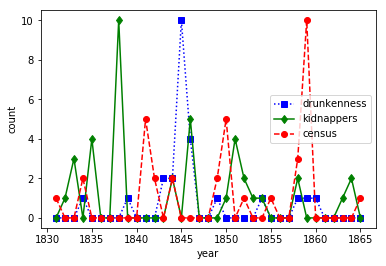

In [59]:
plt.plot(all_years,X_all_years[:,vect.vocabulary_['drunkenness']],'bs:')
plt.plot(all_years,X_all_years[:,vect.vocabulary_['kidnappers']],'gd-')
plt.plot(all_years,X_all_years[:,vect.vocabulary_['census']],'ro--')
plt.legend(['drunkenness','kidnappers','census'])
plt.ylabel('count')
plt.xlabel('year');

**Your turn**. Redo this analysis, using only words that appeared at least 50 times in the dataset.

In [245]:
vect_50 = CountVectorizer(input='filename',min_df=50,binary=False)

In [ ]:
# your code here

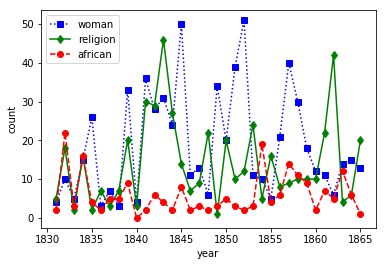

In [252]:
plt.plot(all_years,X_all_years_50[:,vect_50.vocabulary_['woman']],'bs:')
plt.plot(all_years,X_all_years_50[:,vect_50.vocabulary_['religion']],'gd-')
plt.plot(all_years,X_all_years_50[:,vect_50.vocabulary_['african']],'ro--')
plt.legend(['woman','religion','african'])
plt.ylabel('count')
plt.xlabel('year');

# Year-to-year similarity

Next, let's look for transitions in the data.

For each pair of years, we can compute the cosine similarity,

$\cos(x,y) = \frac{x \cdot y}{||x|| \times ||y||}$,

with $\cos(x,y) \in [0,1]$

In [346]:
corr = np.zeros(X_all_years.shape[0]-1)
for i,X_year in enumerate(X_all_years[:-1,]):
    corr[i] = X_year.dot(X_all_years[i+1,]) / ((np.linalg.norm(X_year)) * (np.linalg.norm(X_all_years[i+1,])))

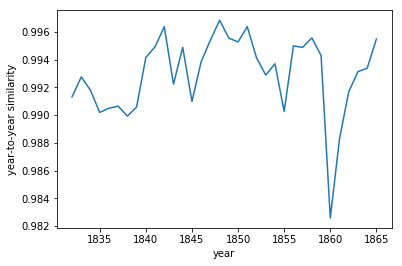

In [347]:
plt.plot(all_years[1:],corr)
plt.xlabel('year')
plt.ylabel('year-to-year similarity');

**Your turn:** Compute the cosine similarity of each year with the sum over the previous three years (when applicable)

# Possible next steps

- Compare the Liberator with other newspaper (ask for this data)
- Apply tf-idf before computing cosine similarity
- Compute topics, track their frequency over time
- Identify named entities, track their frequency over time